In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optim_ls
from tqdm import tqdm

In [2]:
DATA_DIR = "/Users/johnzhou/research/spike-sorting/data/"
OUT_DIR = "/Users/johnzhou/research/spike-sorting/output/"
TOTAL_NUM_CHANNELS = 384 # Neuropixels 2.0 probe

### Plot the waveform templates for visual inspection and remove bad templates

In [3]:
def get_max_chan_temps(templates):
    return templates.ptp(1).argmax(1)

def get_argmin_ptp(templates, max_chan_temp):
    argmin_ptp = np.zeros(templates.shape[0])
    for i in range(templates.shape[0]):
        argmin_ptp[i] = templates[i, :, max_chan_temp[i]].argmin()
        
def plot_templates(templates, max_chan_temp, n_channels=20):
    for i in range(templates.shape[0]):
        print(i)
        plt.figure(figsize = (n_channels, 2.5))
        plt.plot(templates[i, :80, max_chan_temp[i]-n_channels//2:max_chan_temp[i]+n_channels//2].T.flatten())
        for j in range(19):
            plt.axvline(80 + 80*j, color = 'black')
        plt.show()

### Get the 10 templates above and below the channel with max ptp

In [4]:
def take_channel_range(templates, n_channels_loc=20):
    templates_chans = np.zeros((templates.shape[0], templates.shape[1], n_channels_loc))
    templates_chans_ptp = np.zeros((templates.shape[0], n_channels_loc))

    for i in range(templates.shape[0]):
        mc = templates[i].ptp(0).argmax()
        if mc <= n_channels_loc // 2:
            channels_wfs = np.arange(0, n_channels_loc)
        elif mc > TOTAL_NUM_CHANNELS - n_channels_loc:
            channels_wfs = np.arange(TOTAL_NUM_CHANNELS - n_channels_loc, TOTAL_NUM_CHANNELS)
        else:
            up_or_down = templates[i].ptp(0)[mc+2] > templates[i].ptp(0)[mc-2]
            if up_or_down and mc%2 == 0:
                channels_wfs = np.arange(mc - n_channels_loc//2 + 2, mc + n_channels_loc//2 + 2)
            elif up_or_down:
                channels_wfs = np.arange(mc - n_channels_loc//2 + 1, mc + n_channels_loc//2 + 1)
            elif mc%2 == 1:
                channels_wfs = np.arange(mc - n_channels_loc//2 - 1, mc + n_channels_loc//2 - 1)
            else:
                channels_wfs = np.arange(mc - n_channels_loc//2, mc + n_channels_loc//2)
        templates_chans[i] = templates[i,:,channels_wfs].T
        templates_chans_ptp[i] = templates[i,:,channels_wfs].T.ptp(0)

    return templates_chans, templates_chans_ptp

### Estimate positions of templates

In [5]:
def minimize_ls(vec, ptps, channels_pos):
    return (ptps-vec[3]/(((channels_pos - [vec[0], vec[1]])**2).sum(1) + vec[2]**2)**0.5) #**2).sum()

def minimize_ls_bis(vec, ptps, channels_pos):
    return ptps*(((channels_pos - [vec[0], vec[1]])**2).sum(1) + vec[2]**2)**0.5-vec[3] 

def minimize_summed(vec, ptps, channels_pos):
    return ((ptps-vec[3]/(((channels_pos - [vec[0], vec[1]])**2).sum(1) + vec[2]**2)**0.5)**2).sum()

def minimize_de(vec, ptps, channels_pos):
    return (ptps*(((channels_pos - [vec[0], vec[1]])**2).sum(1)+400)**0.5-vec[3]).mean()

def localize_wfs(waveforms_ptp, geom_array):
    n_temp = waveforms_ptp.shape[0]
    output = np.zeros((n_temp, 4))
    channels_pos = geom_array[:waveforms_ptp.shape[1]]
    for i in tqdm(range(n_temp)):
        y_init = 22
        z_com = (waveforms_ptp[i]*channels_pos[:, 1]).sum()/waveforms_ptp[i].sum()
        x_com = (waveforms_ptp[i]*channels_pos[:, 0]).sum()/waveforms_ptp[i].sum()
        alpha_init = waveforms_ptp[i].max()*((((channels_pos - [x_com, z_com])**2).sum(1).min()+y_init**2)**0.5)
        output[i] = optim_ls.least_squares(minimize_ls, x0=[x_com, z_com, y_init, alpha_init], bounds = ([-150, -200, 0, 0], [182, 200, np.max([y_init+10, 150]), np.max([alpha_init+10, 10000])]), 
                                           args=(waveforms_ptp[i], channels_pos), tr_solver='exact')['x']
    return output

### Project templates to new locations

In [12]:
"""This method is modified from the original to only relocate each template once, 
removing the random template sampling"""

def sample_mean_locations(templates, positions_templates, channels_pos, a, loc, scale, size):
    n_samples = templates.shape[0]
    
    gamma = stats.gamma
    y = gamma.rvs(a, loc, scale, size=size)
    
    chan_pos_mean = channels_pos[:, 1].mean()
    alpha = gamma.rvs(a, loc, scale, size=n_samples)
    y = np.random.uniform(0, 150, n_samples)
    x_z = np.zeros((2, n_samples))
    x_z[0, :] = np.random.uniform(-150, 182, n_samples)
    x_z[1, :] = np.random.normal(chan_pos_mean, 25, n_samples)
    idxbool = (y**2 + (x_z[0, :]-16)**2 > 150**2)
    num_outside = idxbool.sum()
    while num_outside > 0:
        y[idxbool] = np.random.uniform(0, 150, num_outside)
        x_z[0, idxbool] = np.random.uniform(-150, 182, num_outside)
        idxbool = (y**2 + (x_z[0, :]-16)**2 > 150**2)
        num_outside = idxbool.sum()
    mean_positions = np.zeros((4, n_samples))
    mean_positions[:2] = x_z
    mean_positions[2] = y
    mean_positions[3] = alpha
    return mean_positions

def relocate_templates(templates, positions_templates, mean_templates, channels_pos, a, loc, scale, 
                       size, n_samples=100):
    
    gamma = stats.gamma
    y = gamma.rvs(a, loc, scale, size=size)
    
    chan_pos_mean = channels_pos[:, 1].mean()
    new_templates = np.zeros((n_samples, templates.shape[1], templates.shape[2]))
    alpha = gamma.rvs(a, loc, scale, size=n_samples)
    y = np.random.uniform(0, 150, n_samples)
    x_z = np.zeros((2, n_samples))
    x_z[0, :] = np.random.uniform(-150, 182, n_samples)
    x_z[1, :] = np.random.normal(chan_pos_mean, 25, n_samples)
    idxbool = (y**2 + (x_z[0, :]-16)**2 > 150**2)
    num_outside = idxbool.sum()
    while num_outside > 0:
        y[idxbool] = np.random.uniform(0, 150, num_outside)
        x_z[0, idxbool] = np.random.uniform(-150, 182, num_outside)
        idxbool = (y**2 + (x_z[0, :]-16)**2 > 150**2)
        num_outside = idxbool.sum()
    relocated_positions = np.zeros((4, n_samples))
    relocated_positions[:2] = x_z
    relocated_positions[2] = y
    relocated_positions[3] = alpha
    idx_units = np.zeros(n_samples)
    for i in tqdm(range(n_samples)):
        idx_temp = i
        idx_units[i] = idx_temp
        # scaling_factor = np.random.uniform(0.8, 1.5)
        for j in range(channels_pos.shape[0]):
            predicted_ptp = positions_templates[idx_temp, 3]/((([positions_templates[idx_temp, 0],
                                                                 positions_templates[idx_temp, 1]] - 
                                                                channels_pos[j])**2).sum() + 
                                                              positions_templates[idx_temp, 2]**2)**0.5
            new_predicted_ptp = alpha[i]/(((x_z[:,i]-channels_pos[j])**2).sum() + y[i]**2)**0.5
            new_templates[i, :, j] = templates[idx_temp, :, j]*new_predicted_ptp/predicted_ptp
    return new_templates, new_templates.ptp(1), relocated_positions, idx_units

### Center templates at the same time point

In [13]:
def time_center_templates(templates_chans):
    centered_templates = np.zeros(templates_chans.shape)
    for i in range(templates_chans.shape[0]):
        mc = templates_chans[i].ptp(0).argmax()
        offset = 42 - templates_chans[i, :, mc].argmin()
        centered_templates[i] = np.roll(templates_chans[i], offset, axis = 0)
    return centered_templates

### Identify bad templates and remove them

In [32]:
templates_fname = "templates_yass.npy"
templates_fpath = os.path.join(DATA_DIR, templates_fname)
templates = np.load(templates_fpath)
geom_fname = "np2_channel_map.npy"
geom_fpath = os.path.join(DATA_DIR, geom_fname)
geom_array = np.load(geom_fpath)
channels_pos = geom_array[:20]

a, loc, scale = 3, 100, 500
size = 20000
n_samples = 100000
n_channels = 20

num_templates, duration, num_channels = templates.shape
print("{} contains {} templates for {} milliseconds across {} channels.".format(
    templates_fname, num_templates, duration, num_channels))

# Manually identify and remove bad templates from plots
bad_template_idxs = [3, 6, 27, 29, 32, 35, 36, 56, 57, 58, 59, 62, 63, 64, 74, 78, 79, 80, 85, 91, 92, \
    101, 107, 109, 110, 111, 118, 119, 121, 145, 150, 151, 152, 157, 159, 164, 165, 169]
good_templates = np.delete(templates, bad_template_idxs, axis=0)
print("Removed {} bad templates, {} remaining.".format(len(bad_template_idxs), good_templates.shape[0]))

templates_yass.npy contains 170 templates for 121 milliseconds across 384 channels.
Removed 38 bad templates, 132 remaining.


### Generate templates with one perturbed feature

In [33]:
"""templates parameter should just be one template to keep everything except perturbed feature constant"""
def relocate_templates_1d(templates, positions_templates, channels_pos, a, loc, scale, 
                       size, pert_feat="x", n_samples=100):
    
    gamma = stats.gamma
    if pert_feat != "alpha":
        alpha_const = gamma.rvs(a, loc, scale)
        alpha = np.full(n_samples, alpha_const)
    else:
        alpha = gamma.rvs(a, loc, scale, size=n_samples)

    chan_pos_mean = channels_pos[:, 1].mean()
    
    new_templates = np.zeros((n_samples, templates.shape[1], templates.shape[2]))
    
    if pert_feat != "y":
        y_const = np.random.uniform(0, 150)
        y = np.full(n_samples, y_const)
    else:
        y = np.random.uniform(0, 150, n_samples)
    
    x_z = np.zeros((2, n_samples))
    
    if pert_feat != "x":
        x_const = np.random.uniform(-150, 182)
        x_z[0, :] = np.full(n_samples, x_const)
    else:
        x_z[0, :] = np.random.uniform(-150, 182, n_samples)
        
    if pert_feat != "z":
        z_const = np.random.normal(chan_pos_mean, 25)
        x_z[1, :] = np.full(n_samples, z_const)
    else:
        x_z[1, :] = np.random.normal(chan_pos_mean, 25, n_samples)
        
    idxbool = (y**2 + (x_z[0, :]-16)**2 > 150**2)
    num_outside = idxbool.sum()
    while num_outside > 0:
        if pert_feat != "y":
            y_const = np.random.uniform(0, 150)
            y = np.full(n_samples, y_const)
        else:
            y[idxbool] = np.random.uniform(0, 150, num_outside)
        if pert_feat != "x":
            x_const = np.random.uniform(-150, 182)
            x_z[0, :] = np.full(n_samples, x_const)
        else:
            x_z[0, idxbool] = np.random.uniform(-150, 182, num_outside)
        idxbool = (y**2 + (x_z[0, :]-16)**2 > 150**2)
        num_outside = idxbool.sum()
    relocated_positions = np.zeros((4, n_samples))
    relocated_positions[:2] = x_z
    relocated_positions[2] = y
    relocated_positions[3] = alpha
    idx_units = np.zeros(n_samples)
    for i in tqdm(range(n_samples)):
        idx_temp = np.random.choice(np.arange(positions_templates.shape[0]))
        idx_units[i] = idx_temp
        for j in range(channels_pos.shape[0]):
            predicted_ptp = positions_templates[idx_temp, 3]/((([positions_templates[idx_temp, 0],
                                                                 positions_templates[idx_temp, 1]] - 
                                                                channels_pos[j])**2).sum() + 
                                                              positions_templates[idx_temp, 2]**2)**0.5
            new_predicted_ptp = alpha[i]/(((x_z[:,i]-channels_pos[j])**2).sum() + y[i]**2)**0.5
            new_templates[i, :, j] = templates[idx_temp, :, j]*new_predicted_ptp/predicted_ptp
    return new_templates, new_templates.ptp(1), relocated_positions, idx_units

### Produce waveform samples with only one varying positional feature

In [184]:
num_neurons = 1
perturb_feature = "alpha"
num_good_templates = good_templates.shape[0]
neuron_template_idxs = [45] # np.random.choice(num_good_templates, size=num_neurons, replace=False)
neuron_templates = np.take(good_templates, neuron_template_idxs, axis=0)
templates_chans, templates_ptp_chans = take_channel_range(neuron_templates, n_channels_loc=n_channels)
positions_templates = localize_wfs(templates_ptp_chans, geom_array)
reloc_templates, reloc_predicted_ptps, reloc_positions, idx_units = relocate_templates_1d(
    templates_chans, positions_templates, channels_pos, a, loc, scale, size, pert_feat=perturb_feature)
print(reloc_templates.shape)
print(reloc_predicted_ptps.shape)
print(reloc_positions.shape)
print(idx_units.shape)
print(reloc_positions[0, :10])

100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 455.96it/s]

(100, 121, 20)
(100, 20)
(4, 100)
(100,)
[74.02262703 74.02262703 74.02262703 74.02262703 74.02262703 74.02262703
 74.02262703 74.02262703 74.02262703 74.02262703]


### Center templates in time and normalize (non-Gaussian, but close enough)

In [185]:
reloc_templates = time_center_templates(reloc_templates)
mean = np.mean(reloc_templates, axis=(0, 1))
var = np.var(reloc_templates, axis=(0, 1))
reloc_templates = (reloc_templates - mean)/var
print(mean)
print(var)

[-0.00841247 -0.01179012 -0.0130412  -0.01648771 -0.00302565 -0.0079288
 -0.00048829  0.00046987  0.00957121  0.01239533  0.01258569  0.01804328
  0.0140054   0.00983746  0.01118689 -0.007516   -0.01202119 -0.00622718
 -0.01065038 -0.00805849]
[ 6.57470365  8.32922971 10.03909201 15.53847326 11.27096337 22.6740446
 11.62717379 26.64076146 11.20945892 32.12973239 11.70617312 35.0574828
 12.55740197 23.3241427  11.46724821 17.63277653  7.38584132  9.93237748
  5.55853846  5.94795447]


### Plot relocated, normalized, and time-centered waveform samples

0


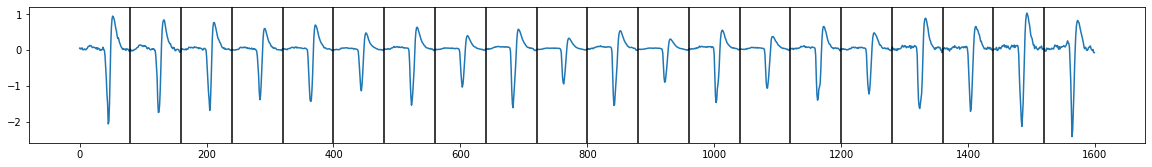

1


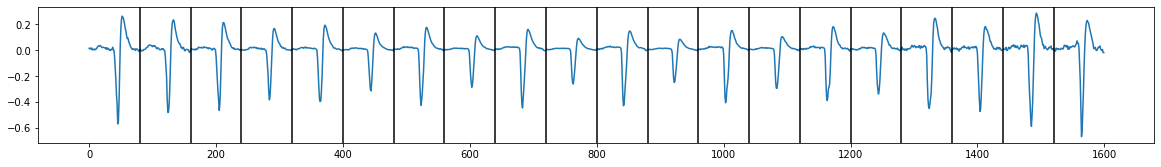

2


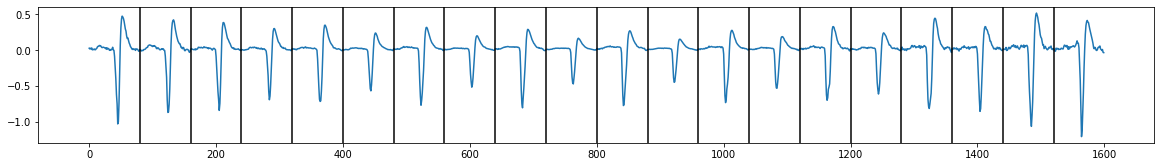

3


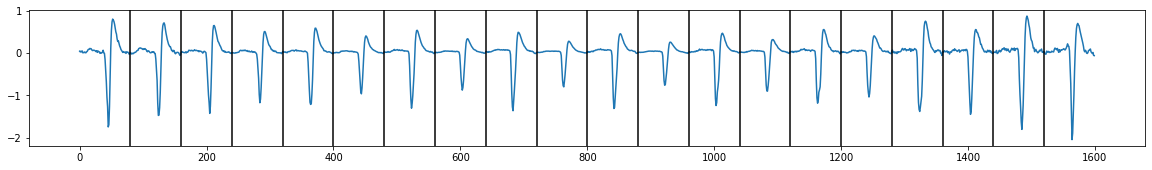

4


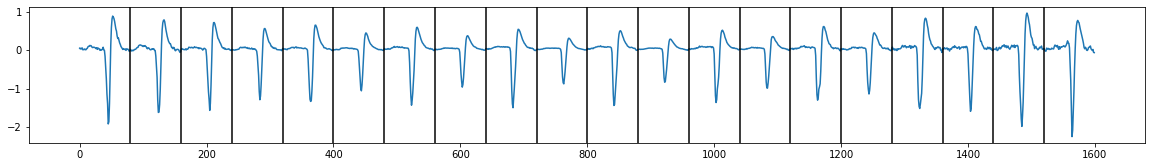

5


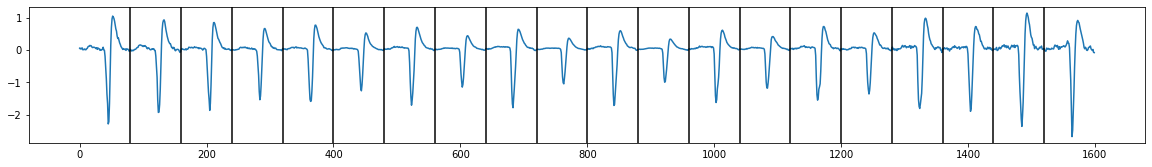

6


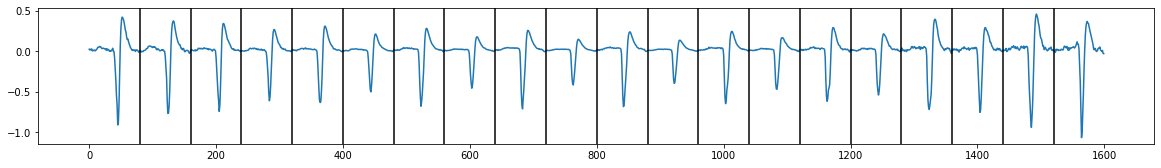

7


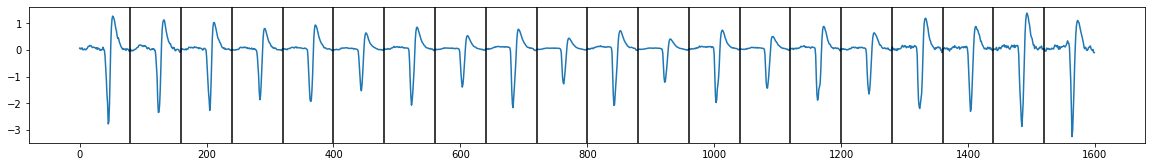

8


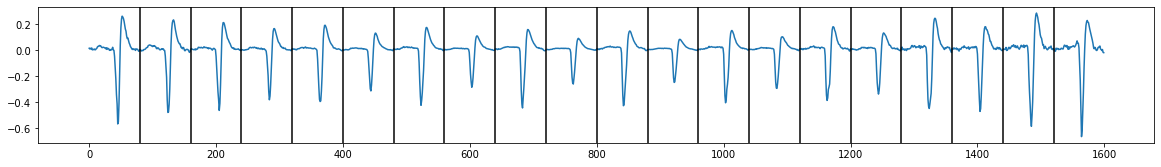

9


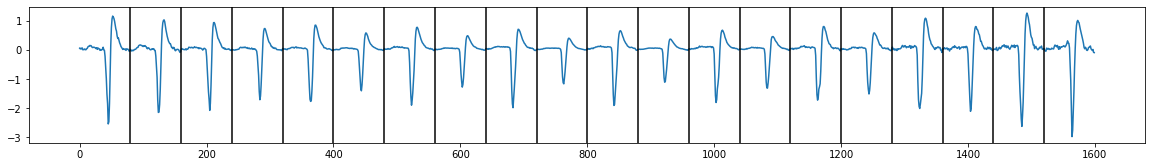

10


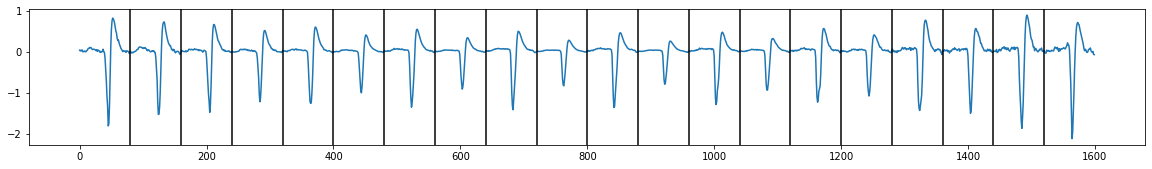

11


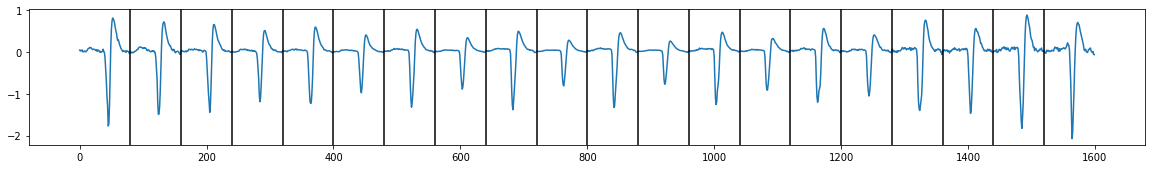

12


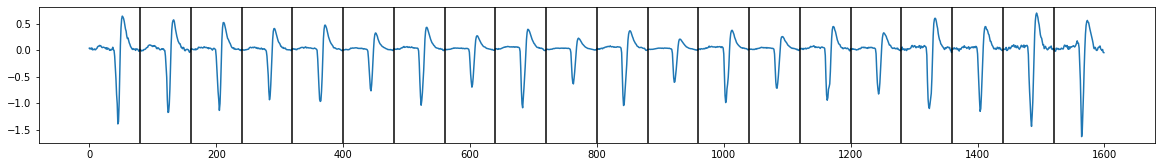

13


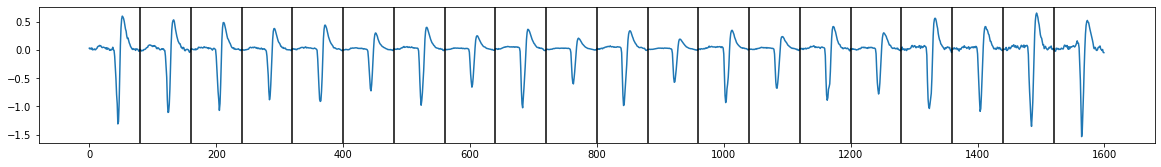

14


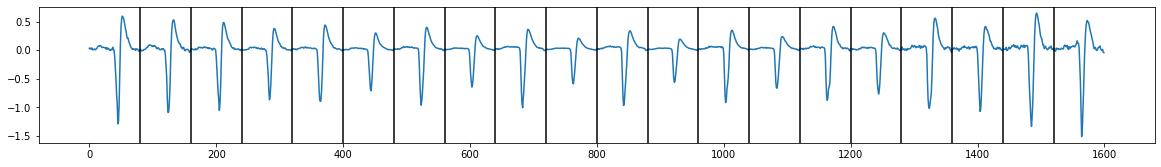

15


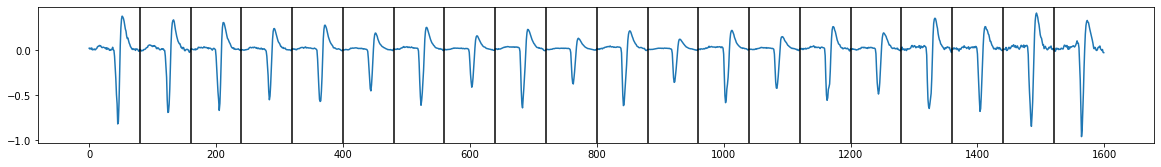

16


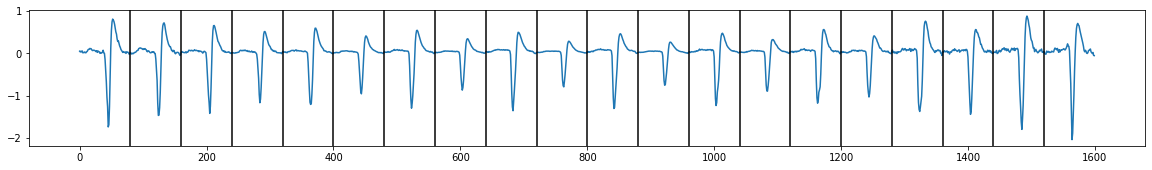

17


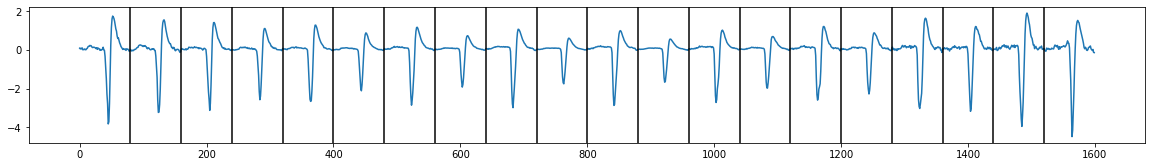

18


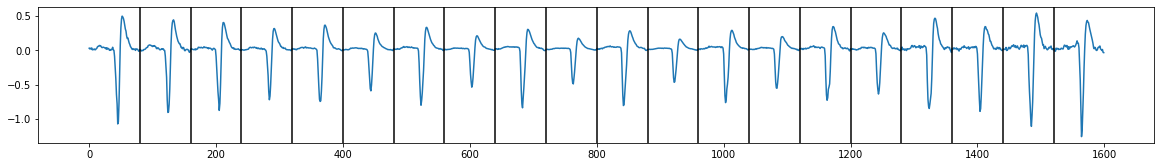

19


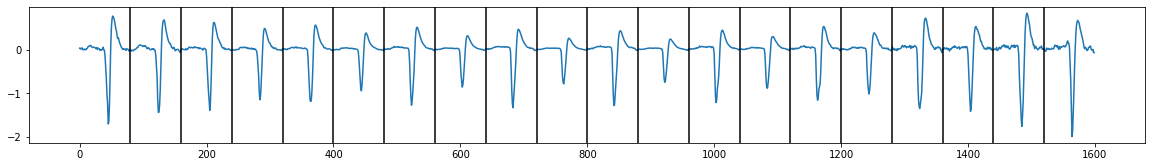

In [186]:
# for i in range(reloc_templates.shape[0]):
for i in range(20):
    print(i)
    plt.figure(figsize = (n_channels, 2.5))
    plt.plot(reloc_templates[i, :80, :].T.flatten())
    for j in range(19):
        plt.axvline(80 + 80*j, color = 'black')
    plt.show()

### Save templates, predicted ptps, positions, and indices of units

In [187]:
print("Saving relocated templates, array of size: {}".format(reloc_templates.shape))
np.save("{}og_templates_{}_vary.npy".format(OUT_DIR, perturb_feature), reloc_templates)
np.save("{}{}_vary_positions.npy".format(OUT_DIR, perturb_feature), reloc_positions)

Saving relocated templates, array of size: (100, 121, 20)


### Compare reconstructed templates (with only 1 changing dim)

In [262]:
num_latents = 12
perturb_feature = "alpha"

og_templates_fname = "og_templates_{}_vary.npy".format(perturb_feature)
og_templates_fpath = os.path.join(OUT_DIR, og_templates_fname)
og_templates = np.load(og_templates_fpath)
print(og_templates.shape)

recon_templates_fname = "recon_templates_{}_vary_latents_{}.npy".format(perturb_feature, num_latents)
recon_templates_fpath = os.path.join(OUT_DIR, recon_templates_fname)
recon_templates = np.load(recon_templates_fpath)
recon_templates = np.swapaxes(recon_templates, 1, 2)
recon_templates = recon_templates/var + mean

(100, 121, 20)


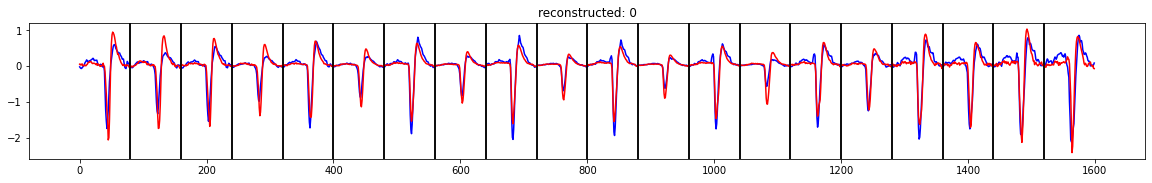

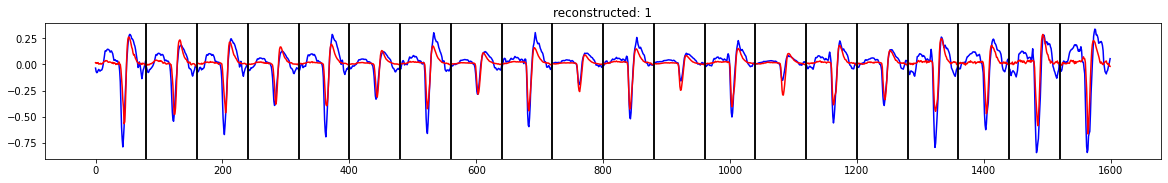

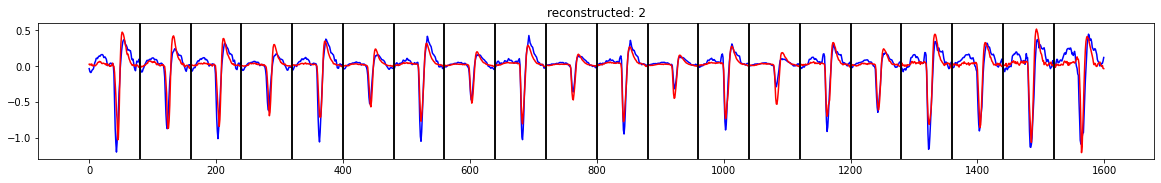

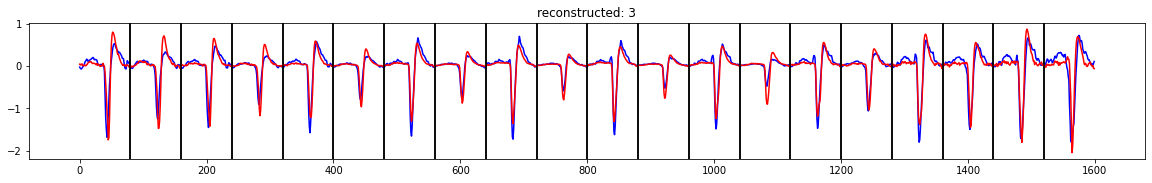

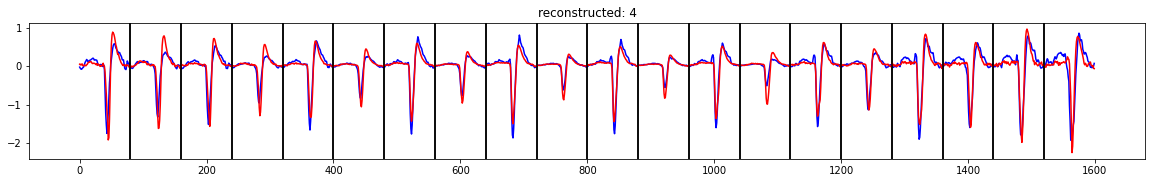

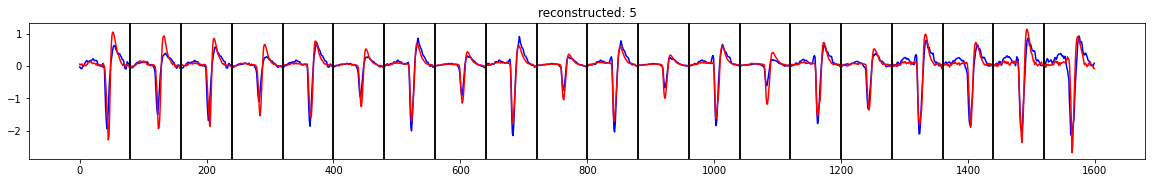

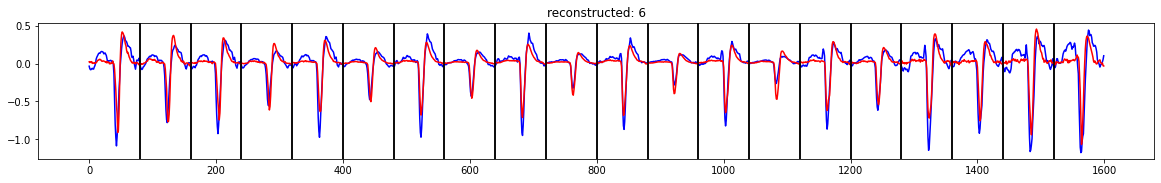

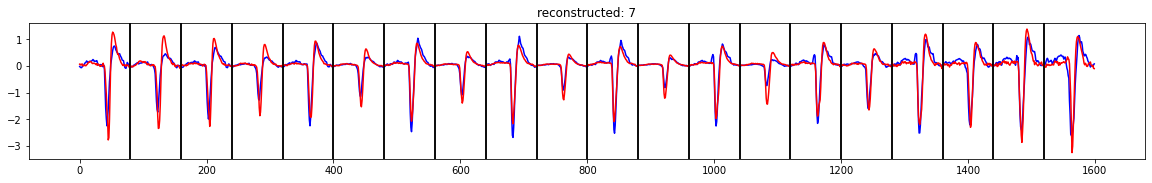

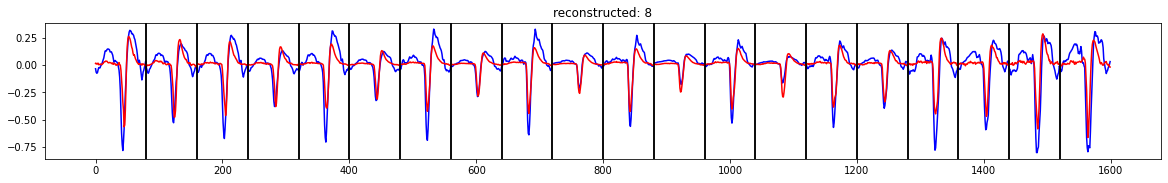

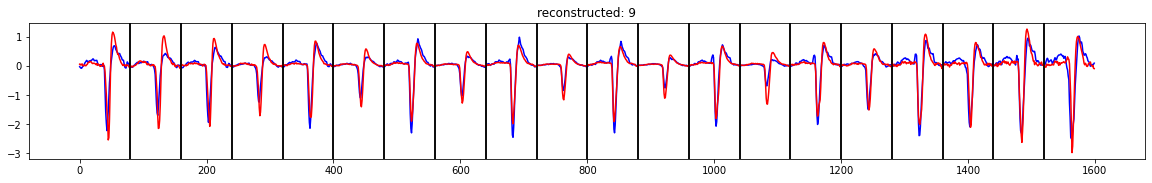

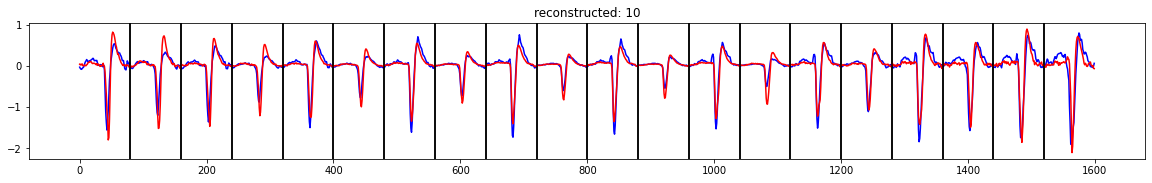

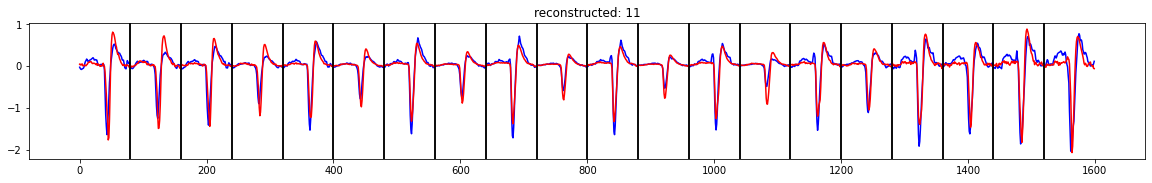

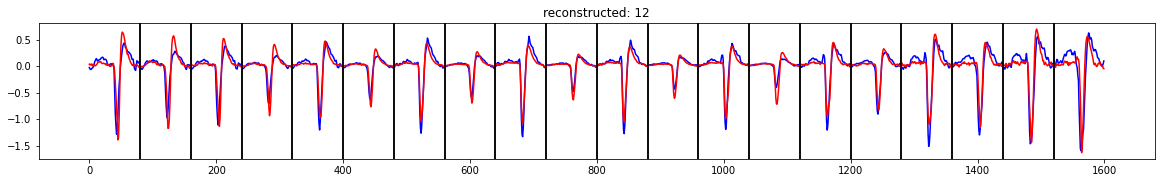

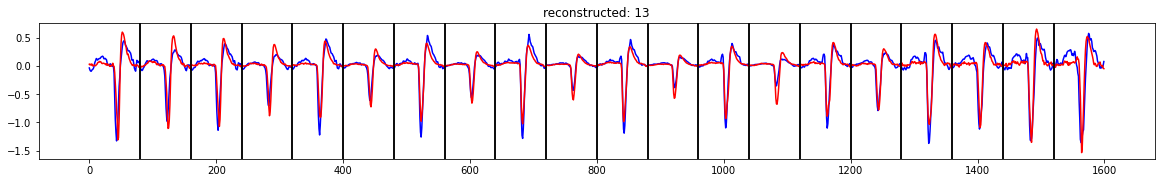

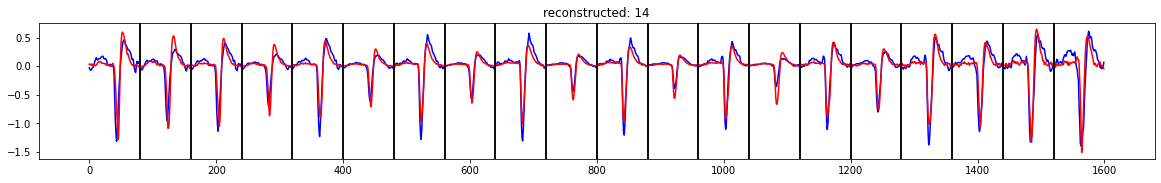

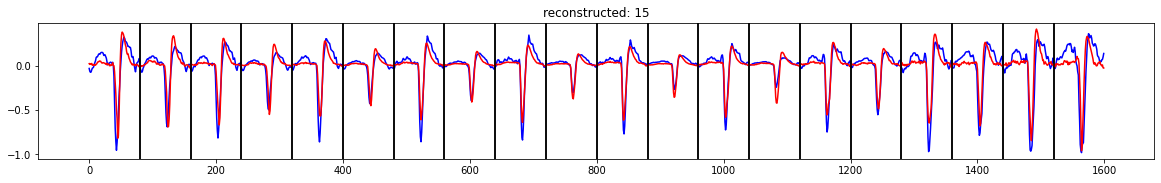

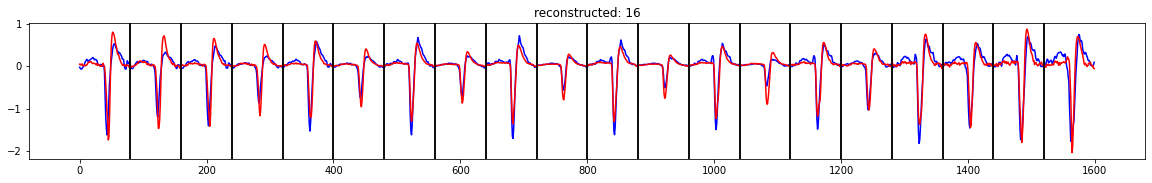

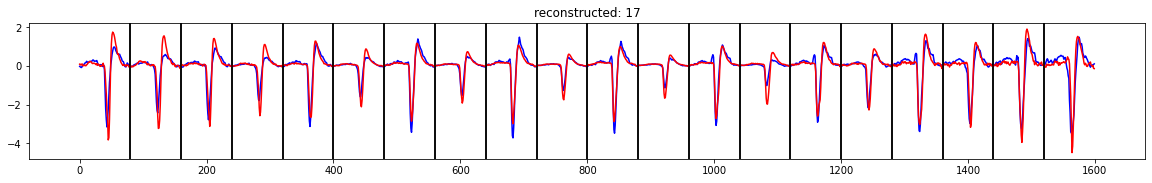

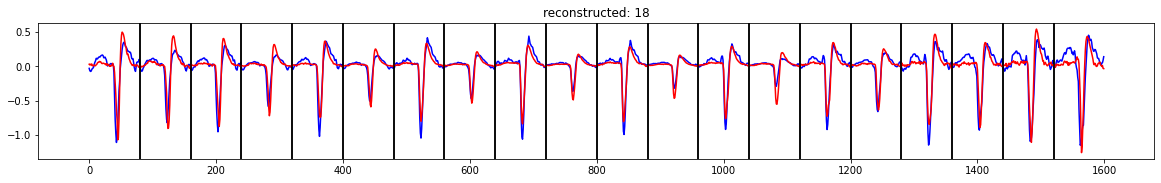

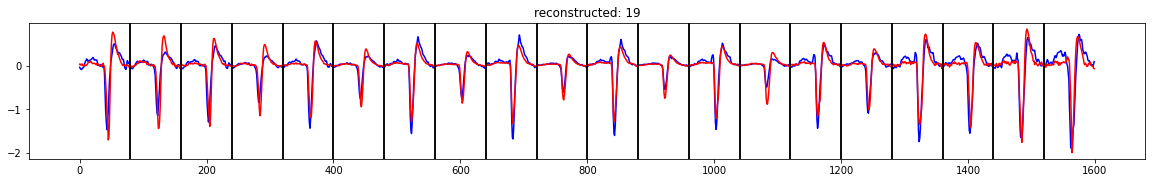

In [263]:
import matplotlib.backends.backend_pdf
n_channels = 20
pdf = matplotlib.backends.backend_pdf.PdfPages(
    "{}visualizations/recon_plots_{}_vary_{}_latents.pdf".format(OUT_DIR, perturb_feature, num_latents))

for i in range(20):
    fig = plt.figure(figsize = (n_channels, 2.5))
    plt.plot(recon_templates[i, :80, :].T.flatten(), color='blue')
    for j in range(19):
        plt.axvline(80 + 80*j, color = 'black')
    plt.plot(og_templates[i, :80, :].T.flatten(), color='red')
    for j in range(19):
        plt.axvline(80 + 80*j, color = 'black')
    plt.title("reconstructed: {}".format(i))
    pdf.savefig(fig)

pdf.close()

### Inspect embedded features for position invariance

In [253]:
import matplotlib.cm as cm

def visualize_latent_space(latent_reps, positions, vary_feature="x"):
    
    num_dims = latent_reps.shape[1]
    fig = plt.figure()
    [xs, zs, ys, alphas] = positions
    if vary_feature == "x":
        x = xs
    elif vary_feature == "z":
        x = zs
    elif vary_feature == "y":
        x = ys
    else:
        x = alphas
    for dim in range(num_dims):
        y = latent_reps[:, dim]
        scatter = plt.scatter(x, y, s=5, cmap="viridis", label=dim);
    plt.title("{} vs. latent dims".format(vary_feature))
    plt.xlabel(vary_feature)
    plt.ylabel("latent dims")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.savefig("{}visualizations/{}_vs_{}_latents.png".format(OUT_DIR, vary_feature, num_dims))



(4, 100)
(100, 12)
(4, 100)
(100, 12)
(4, 100)
(100, 12)
(4, 100)
(100, 12)


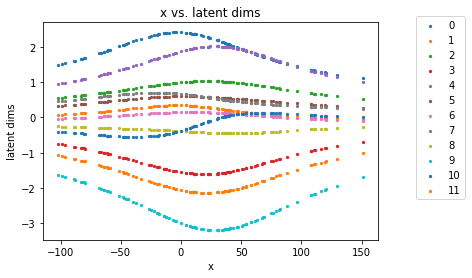

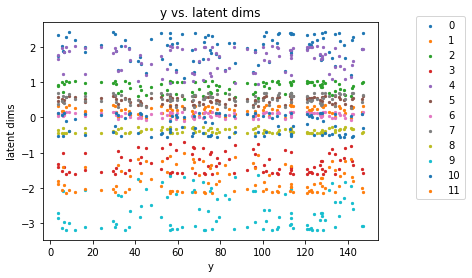

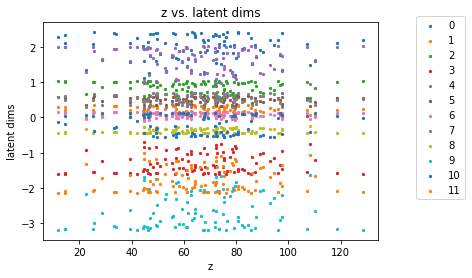

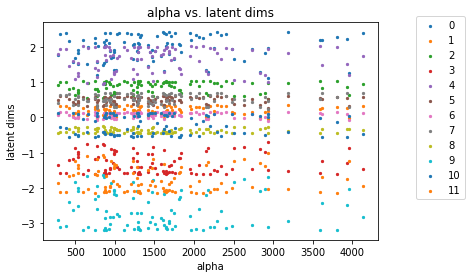

In [254]:
features = ["x", "y", "z", "alpha"]

num_latents = 12

for feat in features:
    
    position_fname = "{}_vary_positions.npy".format(feat)
    positions = np.load(OUT_DIR + position_fname)
    print(positions.shape)
    # 0: x, 1: z, 2: y, 3: alpha
    [xs, zs, ys, alphas] = positions

    latent_fname = "represent_{}_vary_latents_{}.npy".format(vary_feature, num_latents)
    latent_rep = np.load(OUT_DIR + latent_fname)
    print(latent_rep.shape)
    visualize_latent_space(latent_rep, positions, vary_feature=feat)